# 2. Fasea: Algoritmoak diseinatzen

**Julen Etxaniz eta Aitor Zubillaga**

Community Detection proiektuaren 1. fasea entregatu duzue, eta feedback-a jaso ere. Klasean hainbat algoritmo ikusi ditugu, batzuk soluzio bakarrean oinarritutakoak, beste batzuk aldiz, populazio bat erabiltzen dutenak. Horiez gain, hibridatzeko teknikak ere ikusi ditugu. Bigarrengo fase honetan, bi algoritmo diseinatu beharko dituzue, bata soluzio bakarrean oinarritutakoa, eta bestea poblazionala. Ez hori bakarrik, bi algoritmoetako batek operadore probabilistikoak erabili beharko ditu, Estimation of Distribution Algorithms (EDAk) edo Ant Colony Optimization (ACO)-ek egiten duten bezala. Algoritmoen helburua, komunitate kopuru jakin bat emanik, modularity maximizatzen duen komunitate banaketa (soluzioa) bilatzen saiatzea da.

Errepasatu gaitegian zehar ikusi ditugun algoritmo guztiak, eta horiek kontuak izanik, libre zarete nahi dituzuen diseinuak sortzeko, baita ere hibridoak! Adi! Egiten duzuen aukeraketa argudiatu egin beharko duzue.


#### Entregablea

Bigarrengo fasea ebaluatu ahal izateko, notebook honetan bertan algoritmoen diseinua eta implementazioa proposatu beharko duzue. Gogoratu algoritmo bat azaltzeko modurik errezena diagrama bat egitea dela. Adi! Atal bakoitzean hartutako erabakiak eta garatutako metodoak egoki argudiatu beharko dituzue. Ez argudiatzeak edo lana garaiz ez entregatzeak penalizazioa jasoko dute ebaluagarria den proiektuaren zati honetan. eGelan zehazten dira notebook-a igotzeko <b>egun eta orduak</b>.

Momentuz, ez daukazue algoritmoen exekuzio eta konparaketak egin behar. Hirugarren fasean, esperimentazioaren inguruko baldintzak emango dizkizuet, eta, horrez gain, txostenaren idazketa burutu beharko duzue.

## Aukeraketa

```python
## Hemendik aurrera, intuizioa da nagusi...

Nire aukeraketa, UMDA bat swap-LS batekin eta metodo eraikitzaile batekin.

Eta bestea, ILS bat, metodo eraikitzaile estokastiko batekin eta,
```



## Grafoa sortu

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/BH/Proiektua - Community Detection

/content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/BH/Proiektua - Community Detection


In [5]:
%cd /content/drive/MyDrive/Proiektua - Community Detection

[Errno 2] No such file or directory: '/content/drive/MyDrive/Proiektua - Community Detection'
/content/drive/MyDrive/Ingeniaritza Informatikoa/4. Maila/2. Lauhilekoa/BH/Proiektua - Community Detection


In [6]:
import random
import numpy as np
random.seed(1)
np.random.seed(1)

In [7]:
# SQL
import sqlite3

# Pandas
import pandas as pd

# Graph
import community
import networkx as nx

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Combinations
import itertools

def sortu_grafoa():
    # Get data
    connect = sqlite3.connect('data/database.sqlite')
    query = """
    SELECT pa.paper_id, pa.author_id, a.name
    FROM paper_authors AS pa JOIN papers AS p ON pa.paper_id = p.id
    JOIN authors as a ON pa.author_id = a.id
    WHERE p.Year BETWEEN '2014' AND '2015'
    """
    df = pd.read_sql(query, connect)

    # Have a look at data
    df.head(10)

    # Initialize graph
    G = nx.Graph()

    # Transform
    # Autorearen IDa erabili beharrean erabili izena.
    for p, a in df.groupby('paper_id')['name']: 
        for u, v in itertools.combinations(a, 2):
            if G.has_edge(u, v):
                G[u][v]['weight'] +=1
            else:
                G.add_edge(u, v, weight=1)
                
    # Print graph size
    print('Autore kopurua grafoan:', G.number_of_nodes())
    print('Elkarlan kopurua grafoan:', G.number_of_edges())
    
    return G

def bistaratu_grafoa(G):
    plt.figure(figsize=(13, 9))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = 20, node_color='0.75', label=True)
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=1)
    plt.show()

    plt.axis('off')
    plt.show()

In [8]:
G = sortu_grafoa()

Autore kopurua grafoan: 1843
Elkarlan kopurua grafoan: 3215


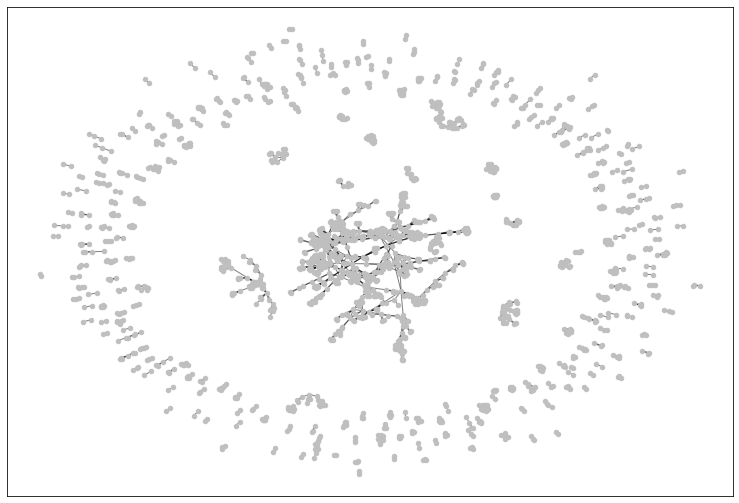

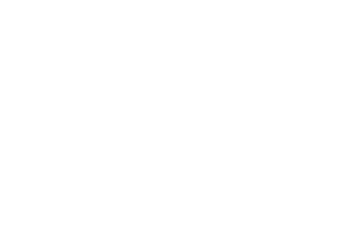

In [9]:
bistaratu_grafoa(G)

## Helburu-funtzioa

In [10]:
from collections import defaultdict

### Helburu-funtzioa
def modularity(G, partition, weight='weight'):
    weights = defaultdict(int)
    degrees = defaultdict(int)
    sum = G.size(weight=weight)
    modularity = 0

    for node in G:
        community = partition[node]
        degrees[community] += G.degree(node, weight=weight)
        for neighbour, data in G[node].items():
            if partition[neighbour] == community:
                if neighbour == node: # 4 nodes have self edges
                    weights[community] += data[weight] * 2
                else:
                    weights[community] += data[weight]

    for community in set(partition.values()):
        modularity += (weights[community] / (2 * sum)) - (degrees[community] / (2 * sum)) ** 2
    return modularity

## Louvain Heuristikoa

Community library https://python-louvain.readthedocs.io/en/latest/

https://github.com/taynaud/python-louvain/tree/master/community

CDLib library https://cdlib.readthedocs.io/en/latest/

Fast unfolding of communities in large networks https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008/meta

### Diseinua

![Louvain](https://drive.google.com/uc?export=view&id=1Io2J3mHJ-mFTYVk0XDMkbeBsfpcrStOf)

### Inplementazioa

In [11]:
class Status(object):
    """
    To handle several data in one struct.
    
    Could be replaced by named tuple, but don't want to depend on python 2.6
    """
    node2com = {}
    total_weight = 0
    internals = {}
    degrees = {}
    gdegrees = {}

    def __init__(self):
        self.node2com = defaultdict(int)
        self.total_weight = 0
        self.degrees = defaultdict(int)
        self.gdegrees = defaultdict(int)
        self.internals = defaultdict(int)
        self.loops = defaultdict(int)

    def __str__(self):
        return ("node2com : " + str(self.node2com) + " degrees : "
                + str(self.degrees) + " internals : " + str(self.internals)
                + " total_weight : " + str(self.total_weight))

    def copy(self):
        """Perform a deep copy of status"""
        new_status = Status()
        new_status.node2com = self.node2com.copy()
        new_status.internals = self.internals.copy()
        new_status.degrees = self.degrees.copy()
        new_status.gdegrees = self.gdegrees.copy()
        new_status.total_weight = self.total_weight

    def init(self, graph, weight, part=None):
        """Initialize the status of a graph with every node in one community"""
        count = 0
        self.node2com = defaultdict(int)
        self.total_weight = 0
        self.degrees = defaultdict(int)
        self.gdegrees = defaultdict(int)
        self.internals = defaultdict(int)
        self.total_weight = graph.size(weight=weight)
        if part is None:
            for node in graph.nodes():
                self.node2com[node] = count
                deg = float(graph.degree(node, weight=weight))
                if deg < 0:
                    error = "Bad node degree ({})".format(deg)
                    raise ValueError(error)
                self.degrees[count] = deg
                self.gdegrees[node] = deg
                edge_data = graph.get_edge_data(node, node, default={weight: 0})
                self.loops[node] = float(edge_data.get(weight, 1))
                self.internals[count] = self.loops[node]
                count += 1
        else:
            for node in graph.nodes():
                com = part[node]
                self.node2com[node] = com
                deg = float(graph.degree(node, weight=weight))
                self.degrees[com] += deg
                self.gdegrees[node] = deg
                inc = 0.
                for neighbor, datas in graph[node].items():
                    edge_weight = datas[weight]
                    if edge_weight <= 0:
                        error = "Bad graph type ({})".format(type(graph))
                        raise ValueError(error)
                    if part[neighbor] == com:
                        if neighbor == node:
                            inc += float(edge_weight) * 2
                        else:
                            inc += float(edge_weight)
                self.internals[com] += inc

In [12]:
import numbers

import networkx as nx
import numpy as np

__PASS_MAX = -1
__MIN = 0.0000001


def check_random_state(seed):
    """Turn seed into a np.random.RandomState instance.
    Parameters
    ----------
    seed : None | int | instance of RandomState
        If seed is None, return the RandomState singleton used by np.random.
        If seed is an int, return a new RandomState instance seeded with seed.
        If seed is already a RandomState instance, return it.
        Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, (numbers.Integral, np.integer)):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError("%r cannot be used to seed a numpy.random.RandomState"
                     " instance" % seed)


def partition_at_level(dendrogram, level):
    """Return the partition of the nodes at the given level
    A dendrogram is a tree and each level is a partition of the graph nodes.
    Level 0 is the first partition, which contains the smallest communities,
    and the best is len(dendrogram) - 1.
    The higher the level is, the bigger are the communities
    Parameters
    ----------
    dendrogram : list of dict
       a list of partitions, ie dictionnaries where keys of the i+1 are the
       values of the i.
    level : int
       the level which belongs to [0..len(dendrogram)-1]
    Returns
    -------
    partition : dictionnary
       A dictionary where keys are the nodes and the values are the set it
       belongs to
    """
    partition = dendrogram[0].copy()
    for index in range(1, level + 1):
        for node, community in partition.items():
            partition[node] = dendrogram[index][community]
    return partition


def best_partition(graph, partition=None, weight='weight', resolution=1., random_state=None):
    """Compute the partition of the graph nodes which maximises the modularity
    (or try..) using the Louvain heuristices
    This is the partition of highest modularity, i.e. the highest partition
    of the dendrogram generated by the Louvain algorithm.
    Parameters
    ----------
    graph : networkx.Graph
       the networkx graph which is decomposed
    partition : dict, optional
       the algorithm will start using this partition of the nodes.
       It's a dictionary where keys are their nodes and values the communities
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'
    resolution :  double, optional
        Will change the size of the communities, default to 1.
        represents the time described in
        "Laplacian Dynamics and Multiscale Modular Structure in Networks",
        R. Lambiotte, J.-C. Delvenne, M. Barahona
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    Returns
    -------
    partition : dictionnary
       The partition, with communities numbered from 0 to number of communities
    """
    dendo = generate_dendrogram(graph, partition, weight, resolution, random_state)
    return partition_at_level(dendo, len(dendo) - 1)


def generate_dendrogram(graph, part_init=None, weight='weight', resolution=1., random_state=None):
    """Find communities in the graph and return the associated dendrogram
    A dendrogram is a tree and each level is a partition of the graph nodes.
    Level 0 is the first partition, which contains the smallest communities,
    and the best is len(dendrogram) - 1. The higher the level is, the bigger
    are the communities
    Parameters
    ----------
    graph : networkx.Graph
        the networkx graph which will be decomposed
    part_init : dict, optional
        the algorithm will start using this partition of the nodes. It's a
        dictionary where keys are their nodes and values the communities
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'
    resolution :  double, optional
        Will change the size of the communities, default to 1.
        represents the time described in
        "Laplacian Dynamics and Multiscale Modular Structure in Networks",
        R. Lambiotte, J.-C. Delvenne, M. Barahona
    Returns
    -------
    dendrogram : list of dictionaries
        a list of partitions, ie dictionnaries where keys of the i+1 are the
        values of the i. and where keys of the first are the nodes of graph
    """
    if graph.is_directed():
        raise TypeError("Bad graph type, use only non directed graph")

    random_state = check_random_state(random_state)

    # special case, when there is no link
    # the best partition is everyone in its community
    if graph.number_of_edges() == 0:
        part = dict([])
        for i, node in enumerate(graph.nodes()):
            part[node] = i
        return [part]

    current_graph = graph.copy()
    status = Status()
    status.init(current_graph, weight, part_init)
    status_list = list()
    level = 0
    unique_values = set()
    while level <= 4 and len(unique_values) != __PASS_MAX:
        __one_level(current_graph, status, weight, resolution, random_state)
        partition = __renumber2(status.node2com)
        unique_values = set(partition.values())
        status_list.append(partition)
        current_graph = induced_graph(partition, current_graph, weight)
        status.init(current_graph, weight)
        level += 1
    return status_list[:]


def induced_graph(partition, graph, weight="weight"):
    """Produce the graph where nodes are the communities
    there is a link of weight w between communities if the sum of the weights
    of the links between their elements is w
    Parameters
    ----------
    partition : dict
       a dictionary where keys are graph nodes and  values the part the node
       belongs to
    graph : networkx.Graph
        the initial graph
    weight : str, optional
        the key in graph to use as weight. Default to 'weight'
    Returns
    -------
    g : networkx.Graph
       a networkx graph where nodes are the parts
    """
    ret = nx.Graph()
    ret.add_nodes_from(partition.values())

    for node1, node2, datas in graph.edges(data=True):
        edge_weight = datas[weight]
        com1 = partition[node1]
        com2 = partition[node2]
        w_prec = ret.get_edge_data(com1, com2, {weight: 0}).get(weight, 1)
        ret.add_edge(com1, com2, **{weight: w_prec + edge_weight})

    return ret


def __renumber(dictionary):
    """Renumber the values of the dictionary from 0 to n
    """
    values = set(dictionary.values())
    target = set(range(len(values)))

    if values == target:
        # no renumbering necessary
        ret = dictionary.copy()
    else:
        # add the values that won't be renumbered
        renumbering = dict(zip(target.intersection(values),
                               target.intersection(values)))
        # add the values that will be renumbered
        renumbering.update(dict(zip(values.difference(target),
                                    target.difference(values))))
        ret = {k: renumbering[v] for k, v in dictionary.items()}
    return ret


def __renumber2(dictionary):
    """Renumber the values of the dictionary from 0 to n
    """
    values = np.array(list(dictionary.values()))
    values += len(values) + 1
    search_list = []
    solution_list = np.zeros((len(values) + 1), dtype=int)
    n = 0
    for val in values:
        if val not in search_list:
            index_list = [i for i, e in enumerate(values) if e == val]
            for j in index_list:
                solution_list[j] = n
            search_list.append(val)
            n += 1
    # add the values that won't be renumbered
    ret = dict(zip(dictionary.keys(), solution_list))
    return ret


def __one_level(graph, status, weight_key, resolution, random_state):
    """Compute one level of communities
    """
    modified = True
    cur_mod = __modularity(status, resolution)
    new_mod = cur_mod
    dic = __renumber(status.node2com)
    unique_values = set(dic.values())
    while modified and len(unique_values) != __PASS_MAX:
        cur_mod = new_mod
        modified = False
        for node in __randomize(graph.nodes(), random_state):
            com_node = status.node2com[node]
            degc_totw = status.gdegrees.get(node, 0.) / (status.total_weight * 2.)  # NOQA
            neigh_communities = __neighcom(node, graph, status, weight_key)
            remove_cost = - resolution * neigh_communities.get(com_node,0) + \
                (status.degrees.get(com_node, 0.) - status.gdegrees.get(node, 0.)) * degc_totw
            __remove(node, com_node,
                     neigh_communities.get(com_node, 0.), status)
            best_com = com_node
            best_increase = -100000000000
            for com, dnc in __randomize(neigh_communities.items(), random_state):
                incr = remove_cost + resolution * dnc - status.degrees[com] * degc_totw
                if incr > best_increase:
                    best_increase = incr
                    best_com = com
            __insert(node, best_com, neigh_communities[best_com], status)
            if best_com != com_node:
                modified = True
                dic = __renumber(status.node2com)
                unique_values = set(dic.values())
                if len(unique_values) == __PASS_MAX:
                    break
        new_mod = __modularity(status, resolution)
        if new_mod - cur_mod < __MIN :
            break


def __neighcom(node, graph, status, weight_key):
    """
    Compute the communities in the neighborhood of node in the graph given
    with the decomposition node2com
    """
    weights = defaultdict(int)
    for neighbor, datas in graph[node].items():
        if neighbor != node:
            neighborcom = status.node2com[neighbor]
            weights[neighborcom] += datas[weight_key]
    return weights


def __remove(node, com, weight, status):
    """ Remove node from community com and modify status"""
    status.degrees[com] -= status.gdegrees[node]
    status.internals[com] -= weight + status.loops[node]
    status.node2com[node] = -1


def __insert(node, com, weight, status):
    """ Insert node into community and modify status"""
    status.node2com[node] = com
    status.degrees[com] += status.gdegrees[node]
    status.internals[com] += weight + status.loops[node]


def __modularity(status, resolution):
    """
    Fast compute the modularity of the partition of the graph using
    status precomputed
    """
    links = float(status.total_weight)
    result = 0.
    for community in set(status.node2com.values()):
        in_degree = status.internals[community]
        degree = status.degrees[community]
        if links > 0:
            result += in_degree * resolution / (2 * links) -  ((degree / (2. * links)) ** 2)
    return result


def __randomize(items, random_state):
    """Returns a List containing a random permutation of items"""
    randomized_items = list(items)
    random_state.shuffle(randomized_items)
    return randomized_items


def best_fixed_partition(G, n):
    global __PASS_MAX
    __PASS_MAX = n
    partition = best_partition(G)
    count = max(partition.values())+1
    modul = modularity(G, partition)
    randomN = random.randint(0, __PASS_MAX - 1)
    if __PASS_MAX < count:
        for key, value in partition.items():
            if value >= __PASS_MAX:
                # partition[key] = randomN
                partition[key] = __PASS_MAX - 1
    return partition

In [13]:
dendo = community.generate_dendrogram(G)
for level in range(len(dendo)):
    partition = community.partition_at_level(dendo, level)
    count = max(partition.values())+1
    modul = community.modularity(partition, G)
    print("partition at level", level, "has", count, "communities", "and", modul, "modularity", partition)

partition at level 0 has 501 communities and 0.8168113952888538 modularity {'Nan Li': 187, 'Rong Jin': 187, 'Zhi-Hua Zhou': 354, 'Fajwel Fogel': 4, "Alexandre d'Aspremont": 4, 'Milan Vojnovic': 4, 'Nisheeth Srivastava': 8, 'Ed Vul': 8, 'Paul R. Schrater': 8, 'Sewoong Oh': 458, 'Devavrat Shah': 281, 'Siu On Chan': 11, 'Ilias Diakonikolas': 11, 'Rocco A. Servedio': 11, 'Xiaorui Sun': 11, 'Aaron van den Oord': 15, 'Benjamin Schrauwen': 15, 'Robert A. Vandermeulen': 18, 'Clayton Scott': 18, 'Qiang Liu': 19, 'Alexander T. Ihler': 19, 'Joseph G. Makin': 22, 'Philip N. Sabes': 22, 'Isabel Valera': 49, 'Zoubin Ghahramani': 24, 'Kumar Dubey': 178, 'Qirong Ho': 178, 'Sinead A. Williamson': 178, 'Eric P. Xing': 178, 'Anqi Wu': 32, 'Mijung Park': 459, 'Oluwasanmi O. Koyejo': 98, 'Jonathan W. Pillow': 32, 'Balaji Lakshminarayanan': 340, 'Daniel M. Roy': 340, 'Yee Whye Teh': 340, 'Jason Chang': 160, 'John W. Fisher III': 160, 'Mehmet G?nen': 38, 'Adam A. Margolin': 38, 'Qichao Que': 40, 'Mikhail Bel

In [14]:
dendo = generate_dendrogram(G)
for level in range(len(dendo)):
    partition = partition_at_level(dendo, level)
    count = max(partition.values())+1
    modul = modularity(G, partition)
    print("partition at level", level, "has", count, "communities", "and", modul, "modularity", partition)

partition at level 0 has 504 communities and 0.810603404510165 modularity {'Nan Li': 0, 'Rong Jin': 0, 'Zhi-Hua Zhou': 1, 'Fajwel Fogel': 2, "Alexandre d'Aspremont": 2, 'Milan Vojnovic': 2, 'Nisheeth Srivastava': 3, 'Ed Vul': 3, 'Paul R. Schrater': 3, 'Sewoong Oh': 4, 'Devavrat Shah': 5, 'Siu On Chan': 6, 'Ilias Diakonikolas': 6, 'Rocco A. Servedio': 6, 'Xiaorui Sun': 6, 'Aaron van den Oord': 7, 'Benjamin Schrauwen': 7, 'Robert A. Vandermeulen': 8, 'Clayton Scott': 8, 'Qiang Liu': 9, 'Alexander T. Ihler': 9, 'Joseph G. Makin': 10, 'Philip N. Sabes': 10, 'Isabel Valera': 11, 'Zoubin Ghahramani': 12, 'Kumar Dubey': 13, 'Qirong Ho': 13, 'Sinead A. Williamson': 13, 'Eric P. Xing': 13, 'Anqi Wu': 14, 'Mijung Park': 15, 'Oluwasanmi O. Koyejo': 16, 'Jonathan W. Pillow': 14, 'Balaji Lakshminarayanan': 17, 'Daniel M. Roy': 17, 'Yee Whye Teh': 17, 'Jason Chang': 18, 'John W. Fisher III': 18, 'Mehmet G?nen': 19, 'Adam A. Margolin': 19, 'Qichao Que': 20, 'Mikhail Belkin': 21, 'Yusu Wang': 20, 'Bo 

In [15]:
best_part_com = community.best_partition(G)
print("Komunitate kopurua:", max(best_part_com.values())+1)
print("Soluzio onenaren modularitatea:", community.modularity(best_part_com, G))

Komunitate kopurua: 290
Soluzio onenaren modularitatea: 0.9719530984134993


In [16]:
best_part = best_partition(G)
print("Komunitate kopurua:", max(best_part.values())+1)
print("Soluzio onenaren modularitatea:", modularity(G, best_part))

Komunitate kopurua: 276
Soluzio onenaren modularitatea: 0.8979230065632511


In [17]:
best_fixed_part = best_fixed_partition(G, 50)
count = max(best_fixed_part.values())+1
modul = modularity(G, best_fixed_part)
print("partition has", count, "communities", "and", modul, "modularity", best_fixed_part)

partition has 50 communities and 0.704007452106096 modularity {'Nan Li': 0, 'Rong Jin': 0, 'Zhi-Hua Zhou': 0, 'Fajwel Fogel': 1, "Alexandre d'Aspremont": 1, 'Milan Vojnovic': 1, 'Nisheeth Srivastava': 2, 'Ed Vul': 2, 'Paul R. Schrater': 2, 'Sewoong Oh': 3, 'Devavrat Shah': 3, 'Siu On Chan': 4, 'Ilias Diakonikolas': 4, 'Rocco A. Servedio': 4, 'Xiaorui Sun': 4, 'Aaron van den Oord': 5, 'Benjamin Schrauwen': 5, 'Robert A. Vandermeulen': 6, 'Clayton Scott': 6, 'Qiang Liu': 7, 'Alexander T. Ihler': 7, 'Joseph G. Makin': 8, 'Philip N. Sabes': 8, 'Isabel Valera': 9, 'Zoubin Ghahramani': 9, 'Kumar Dubey': 3, 'Qirong Ho': 3, 'Sinead A. Williamson': 3, 'Eric P. Xing': 3, 'Anqi Wu': 3, 'Mijung Park': 3, 'Oluwasanmi O. Koyejo': 3, 'Jonathan W. Pillow': 3, 'Balaji Lakshminarayanan': 3, 'Daniel M. Roy': 3, 'Yee Whye Teh': 3, 'Jason Chang': 7, 'John W. Fisher III': 7, 'Mehmet G?nen': 10, 'Adam A. Margolin': 10, 'Qichao Que': 11, 'Mikhail Belkin': 11, 'Yusu Wang': 11, 'Bo Dai': 9, 'Bo Xie': 9, 'Niao H

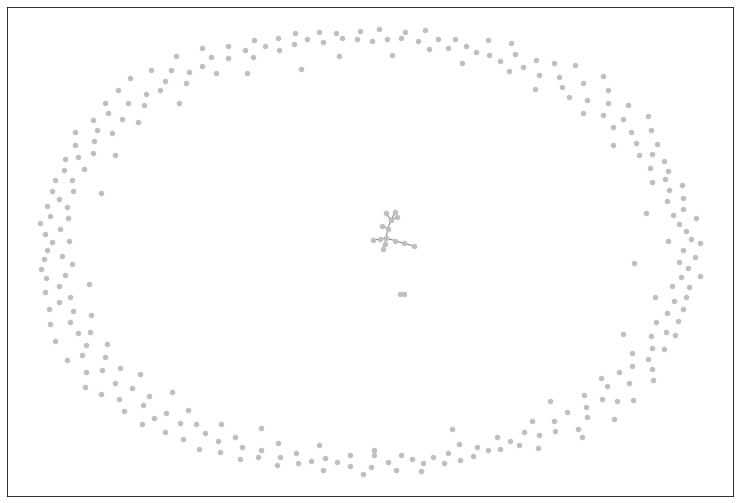

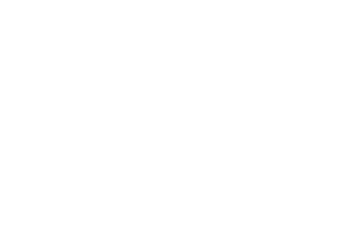

In [18]:
graph_com = community.induced_graph(best_part_com, G)
bistaratu_grafoa(graph_com)

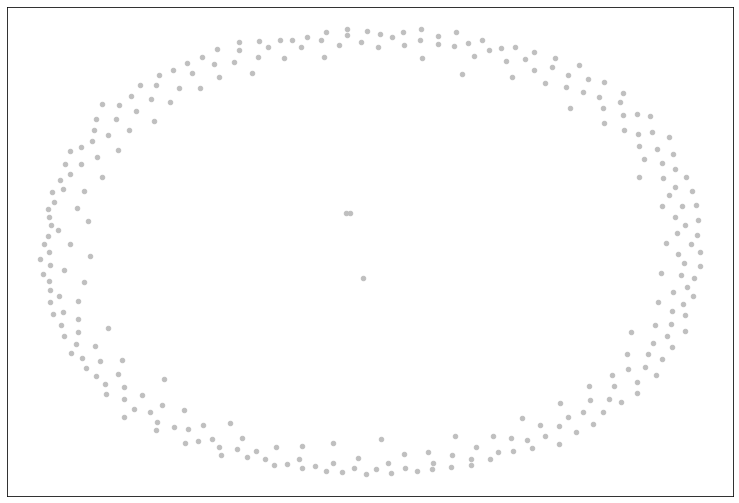

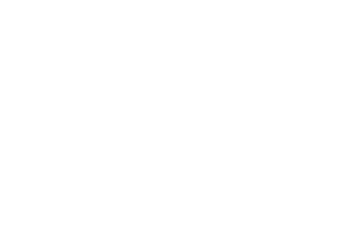

In [19]:
graph = induced_graph(best_part, G)
bistaratu_grafoa(graph)

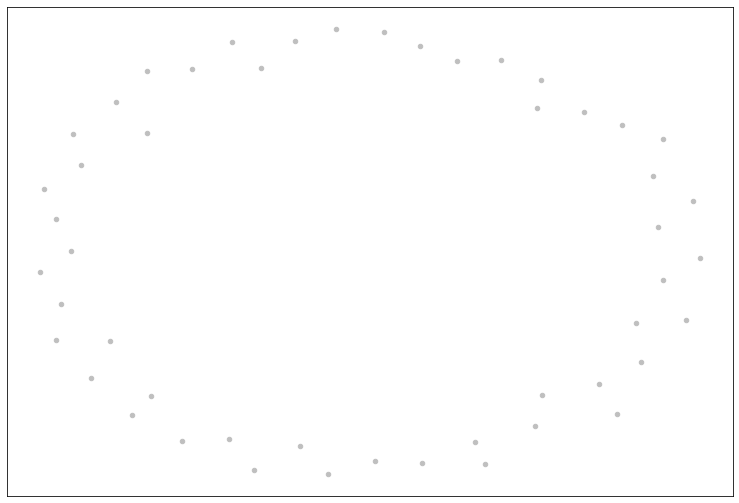

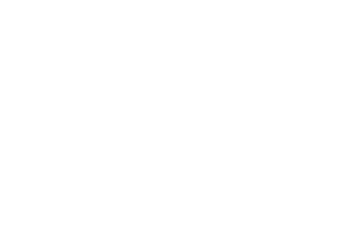

In [20]:
graph_fixed = induced_graph(best_fixed_part, G)
bistaratu_grafoa(graph_fixed)

## Random Search

In [21]:
def random_search(G, num_solutions, com_count):
    size = G.number_of_nodes()
    best_solution = list(np.random.randint(com_count, size=size))
    best_partition = dict(zip(G.nodes, best_solution))
    best_fitness = modularity(G, best_partition)
    for i in range(num_solutions-1):
        solution = list(np.random.randint(com_count, size=size))
        partition = dict(zip(G.nodes, best_solution))
        fitness = modularity(G, best_partition)
        if fitness > best_fitness:
            best_fitness = fitness
            best_solution = solution
    return (best_fitness, best_solution, num_solutions)

## 1. Local Search

community detection local search https://scholar.google.es/scholar?hl=es&as_sdt=0%2C5&q=community+detection+local+search&oq=com

An evolutionary method for community detection using a novel local search strategy https://www.sciencedirect.com/science/article/pii/S0378437119301402

An iterated local search algorithm for community detection in complex networks https://www.worldscientific.com/doi/abs/10.1142/S0217979220500137

A novel iterated greedy algorithm for detecting communities in complex network https://link.springer.com/content/pdf/10.1007/s13278-020-00641-y.pdf

### Diseinua

![ILS](https://drive.google.com/uc?export=view&id=1ItmPvyTUC_ThfOqLzg4mj8MzFG7RsTXU)

### Swap

In [22]:
def swap(solution, i, j):
    solution[i], solution[j] = solution[j], solution[i]
    return solution

def swap_neighbours(solution):
    neighbours = []
    size = len(solution)
    for i in range(size):
        for j in range(i+1, size):
            neighbours.append(swap(solution[:], i, j))
    return neighbours

def best_first_swap(G, best_solution, best_fitness, evals, max_evals):
    improve = False
    size = len(best_solution)
    for i in range(size):
        for j in range(i+1, size):
            solution = swap(best_solution[:], i, j)
            partition = dict(zip(G.nodes, solution))
            fitness = modularity(G, partition)
            evals += 1
            if fitness > best_fitness:
                improve = True
                return (fitness, solution, evals, improve)
            if evals == max_evals:
                return (best_fitness, best_solution, evals, improve)
    return (best_fitness, best_solution, evals, improve)

def local_search_swap(G, max_evals, com_count):
    best_partition = best_fixed_partition(G, com_count)
    best_solution = list(best_partition.values())
    best_fitness = modularity(G, best_partition)
    improve = True
    evals = 1
    while evals < max_evals and improve:
        best_fitness, best_solution, evals, improve = best_first_swap(G, best_solution, best_fitness, evals, max_evals)
        
    return (best_fitness, best_solution, evals)

### Insert

In [23]:
def insert(solution, i, j):
    solution.insert(j, solution.pop(i))
    return solution

def insert_neighbours(solution):
    neighbours = []
    size = len(solution)
    for i in range(size):
        for j in list(range(0, i-1)) + list(range(i+1, size)):
            neighbours.append(insert(solution[:], i, j))
    return neighbours

def best_first_insert(G, best_solution, best_fitness, evals, max_evals):
    improve = False
    size = len(best_solution)
    for i in range(size):
        for j in list(range(0, i-1)) + list(range(i+1, size)):
            solution = insert(best_solution[:], i, j)
            partition = dict(zip(G.nodes, solution))
            fitness = modularity(G, partition)
            evals += 1
            if fitness > best_fitness:
                improve = True
                return (fitness, solution, evals, improve)
            if evals == max_evals:
                return (best_fitness, best_solution, evals, improve)
    return (best_fitness, best_solution, evals, improve)

def local_search_insert(G, max_evals, com_count):
    best_partition = best_fixed_partition(G, com_count)
    best_solution = list(best_partition.values())
    best_fitness = modularity(G, best_partition)
    improve = True
    evals = 1
    while evals < max_evals and improve:
        best_fitness, best_solution, evals, improve = best_first_insert(G, best_solution, best_fitness, evals, max_evals)
        
    return (best_fitness, best_solution, evals)

### Hamming

In [24]:
def hamming(solution, i, cj):
    solution[i] = cj
    return solution

def hamming_neighbours(solution, com_count):
    neighbours = []
    size = len(solution)
    for i in range(size):
        for cj in range(com_count):
            neighbours.append(hamming(solution[:], i, cj))
    return neighbours

def best_first_hamming(G, best_solution, best_fitness, evals, max_evals, com_count):
    improve = False
    size = len(best_solution)
    for i in range(size):
        for j in range(com_count):
            solution = hamming(best_solution[:], i, j)
            partition = dict(zip(G.nodes, solution))
            fitness = modularity(G, partition)
            evals += 1
            if fitness > best_fitness:
                improve = True
                return (fitness, solution, evals, improve)
            if evals == max_evals:
                return (best_fitness, best_solution, evals, improve)
    return (best_fitness, best_solution, evals, improve)

def local_search_hamming(G, max_evals, com_count):
    best_partition = best_fixed_partition(G, com_count)
    best_solution = list(best_partition.values())
    best_fitness = modularity(G, best_partition)
    improve = True
    evals = 1
    while evals < max_evals and improve:
        best_fitness, best_solution, evals, improve = best_first_hamming(G, best_solution, best_fitness, evals, max_evals, com_count)
        
    return (best_fitness, best_solution, evals)

### Merge

In [25]:
def merge(solution, ci, cj):
    # solution[solution == cj] = ci
    size = len(solution)
    for i in range(size):
        if solution[i] == cj:
            solution[i] = ci
    return solution

def merge_neighbours(solution, com_count):
    neighbours = []
    for ci in range(com_count):
        for cj in range(ci + 1, com_count):
            neighbours.append(merge(solution[:], ci, cj))
    return neighbours

def best_first_merge(G, best_solution, best_fitness, evals, max_evals, com_count):
    improve = False
    size = len(best_solution)
    for i in range(com_count):
        for j in range(i + 1, com_count):
            solution = merge(best_solution[:], i, j)
            partition = dict(zip(G.nodes, solution))
            fitness = modularity(G, partition)
            evals += 1
            if fitness > best_fitness:
                improve = True
                return (fitness, solution, evals, improve)
            if evals == max_evals:
                return (best_fitness, best_solution, evals, improve)
    return (best_fitness, best_solution, evals, improve)

def greedy_merge(G, best_solution, best_fitness, evals, max_evals, com_count):
    best_fit = float('-inf')
    improve = False
    neighs = merge_neighbours(best_solution, com_count)
    for n in neighs:
        partition = dict(zip(G.nodes, n))
        fitness = modularity(G, partition)
        evals += 1
        if fitness > best_fit:
            print(n)
            best_solution = n
            best_fit = fitness
        if evals == max_evals:
            break
    if best_fit > best_fitness:
        improve = True
    best_fitness = best_fit
    return (best_fitness, best_solution, evals, improve)

def local_search_merge(G, max_evals, com_count):
    best_part = best_partition(G)
    best_solution = list(best_part.values())
    best_fitness = modularity(G, best_part)
    unique_values = set(best_solution)
    improve = True
    evals = 1
    while evals < max_evals and len(unique_values) > com_count:
        best_fitness, best_solution, evals, improve = greedy_merge(G, best_solution, best_fitness, evals, max_evals, com_count)
        unique_values = set(best_solution)
        print(len(unique_values), evals)
        
    return (best_fitness, best_solution, evals)

In [ ]:
best_fitness, best_solution, evals = local_search_merge(G, 10000, 50)

In [83]:
best_part = best_partition(G)
best_solution = list(best_part.values())
unique_values = set(best_solution)
neighs = merge_neighbours(best_solution, 50)
unique_values2 = set(neighs[0])
print(len(unique_values))
print(len(unique_values2))
print(neighs[0])

276
275
[0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 7, 7, 11, 11, 12, 12, 12, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 9, 9, 9, 13, 13, 13, 14, 14, 13, 13, 3, 3, 15, 15, 3, 3, 3, 3, 3, 16, 16, 3, 3, 3, 10, 10, 17, 17, 17, 17, 3, 3, 3, 3, 3, 18, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 19, 20, 20, 20, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 21, 21, 22, 22, 22, 3, 3, 3, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 26, 26, 27, 27, 27, 28, 28, 10, 10, 10, 20, 20, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 32, 32, 32, 33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 10, 10, 10, 10, 10, 10, 10, 10, 37, 37, 37, 37, 10, 10, 10, 38, 38, 39, 39, 38, 10, 40, 40, 3, 3, 3, 41, 41, 41, 41, 41, 10, 10, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 40, 40, 40, 10, 10, 10, 10, 10, 10, 10, 10, 44, 44, 44, 44, 3, 3, 3, 3, 3, 10, 10, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 10, 10, 10, 42, 42, 45, 45, 45, 45, 46, 46, 

In [92]:
neighs2 = merge_neighbours(neighs[0], 50)
unique_values3 = set(neighs2[0])
print(len(unique_values3))
print(neighs2[0])
print(neighs[0] == neighs2[0])

275
[0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 7, 7, 11, 11, 12, 12, 12, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 9, 9, 9, 13, 13, 13, 14, 14, 13, 13, 3, 3, 15, 15, 3, 3, 3, 3, 3, 16, 16, 3, 3, 3, 10, 10, 17, 17, 17, 17, 3, 3, 3, 3, 3, 18, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 19, 19, 19, 20, 20, 20, 20, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 21, 21, 22, 22, 22, 3, 3, 3, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 26, 26, 27, 27, 27, 28, 28, 10, 10, 10, 20, 20, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 32, 32, 32, 33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 10, 10, 10, 10, 10, 10, 10, 10, 37, 37, 37, 37, 10, 10, 10, 38, 38, 39, 39, 38, 10, 40, 40, 3, 3, 3, 41, 41, 41, 41, 41, 10, 10, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 40, 40, 40, 10, 10, 10, 10, 10, 10, 10, 10, 44, 44, 44, 44, 3, 3, 3, 3, 3, 10, 10, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 10, 10, 10, 42, 42, 45, 45, 45, 45, 46, 46, 46, 

### Simulated Annealing

In [25]:
import random
import math

def initial_temperature(best_fitness):
    return 0.025 * best_fitness

def update_temperature(temp):
    return 0.9 * temp
    
def simmulated_annealing(best_solution, best_fitness, solution, fitness, temp):
    if fitness > best_fitness:
        best_solution = solution
        best_fitness = fitness
    else:
        p = random.uniform(0, 1)
        if p <= math.exp((fitness - best_fitness) / temp):
            best_solution = solution
            best_fitness = fitness
    temp = update_temperature(temp)
    return best_solution, best_fitness, temp

### Iterated Local Search

In [36]:
def local_search_swap(G, best_solution, evals, max_evals, com_count):
    best_partition = dict(zip(G.nodes, best_solution))
    best_fitness = modularity(G, best_partition)
    improve = True
    while evals < max_evals and improve:
        best_fitness, best_solution, evals, improve = best_first_swap(G, best_solution, best_fitness, evals, max_evals)
        
    return (best_fitness, best_solution, evals)

In [37]:
def ILS(G, max_evals, com_count):
    best_partition = best_fixed_partition(G, com_count)
    best_solution = list(best_partition.values())
    best_fitness = modularity(G, best_partition)
    evals = 1
    while evals < max_evals:
        best_solution = perturbate_solution(best_solution, com_count)
        best_partition = dict(zip(G.nodes, best_solution))
        best_fitness = modularity(G, best_partition)
        fitness, solution, evals = local_search_swap(G, best_solution, evals, max_evals, com_count)
        if fitness > best_fitness:
            best_solution = solution
            best_fitness = fitness

    return (best_fitness, best_solution, evals)

In [38]:
def perturbate_solution(best_solution, com_count):
    ci = random.randrange(com_count)
    cj = random.randrange(com_count)
    ck = random.randrange(com_count)
    solution = merge(best_solution, ci, cj)
    solution = split(best_solution, ck)
    return solution

### Eraikitzaile estokastikoa

In [39]:
def LS(G, max_evals, com_count):
    evals = 1
    while evals < max_evals:
        best_partition = best_fixed_partition(G, com_count)
        best_solution = list(best_partition.values())
        best_fitness = modularity(G, best_partition)
        fitness, solution, evals = local_search_swap(G, best_solution, evals, max_evals, com_count)
        if fitness > best_fitness:
            best_solution = solution
            best_fitness = fitness

    return (best_fitness, best_solution, evals)

### Variable Neighbourhood Search

In [40]:
def VNS(G, max_evals, com_count):
    best_partition = best_fixed_partition(G, com_count)
    best_solution = list(best_partition.values())
    best_fitness = modularity(G, best_partition)
    improve = True
    evals = 1
    while evals < max_evals and improve:
        best_fitness, best_solution, evals = local_search_swap(G, best_solution, evals, max_evals, com_count)
        best_fitness, best_solution, evals, improve = best_first_insert(best_solution, best_fitness, evals, max_evals)

    return (best_fitness, best_solution, evals)

### Run Search

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import time as tm

# Egin exekuzioak budget desberdinetarako: 10, 100, 1000, 10000...
def run_search(function, com_count, budget=5, repetitions=5):
    list_budget = []
    list_fit = []
    list_time = []
    for exp in range(1, budget):
        budget=10**exp
        avg_fit = 0
        avg_time = 0
        for rep in tqdm(range(repetitions), position=0, leave=True):
            start = tm.time()
            (fitness, sol, evals) = function(G, budget, com_count)
            end = tm.time()
            avg_time += end - start
            avg_fit += fitness
        avg_fit = avg_fit/repetitions
        avg_time = avg_time/repetitions
        print()
        print("Budget:", budget, " Average fitness:", avg_fit, " Average time:", avg_time)
        list_budget.append(budget)
        list_fit.append(avg_fit)
        list_time.append(avg_time)
    return list_budget, list_fit, list_time

In [148]:
list_budget, list_fit_ls_swap, list_time_ls_swap = run_search(local_search_swap, 50)

  0%|          | 0/5 [00:00<?, ?it/s]


Budget: 10  Average fitness: 0.7484585081861693  Average time: 1.8616358757019043


  0%|          | 0/5 [00:00<?, ?it/s]


Budget: 100  Average fitness: 0.7649809447594166  Average time: 3.853651189804077


  0%|          | 0/5 [00:00<?, ?it/s]


Budget: 1000  Average fitness: 0.7460340075076798  Average time: 23.547870349884032


100%|██████████| 5/5 [18:28<00:00, 221.60s/it]


Budget: 10000  Average fitness: 0.7480171059113744  Average time: 221.60215210914612


In [41]:
list_budget, list_fit_ls_swap, list_time_ls_swap = run_search(LS, 50)

  0%|          | 0/1 [00:00<?, ?it/s]


Budget: 10  Average fitness: 0.704007452106096  Average time: 1.9181087017059326


  0%|          | 0/1 [00:00<?, ?it/s]


Budget: 100  Average fitness: 0.7637728787927824  Average time: 3.9765005111694336


  0%|          | 0/1 [00:00<?, ?it/s]


Budget: 1000  Average fitness: 0.7637728787927824  Average time: 24.157792806625366


100%|██████████| 1/1 [03:45<00:00, 225.93s/it]


Budget: 10000  Average fitness: 0.7637728787927824  Average time: 225.92408728599548


In [59]:
list_budget, list_fit_ls_mer, list_time_ls_mer = run_search(local_search_merge, 50)

  0%|          | 0/5 [00:00<?, ?it/s]


Budget: 10  Average fitness: 0.9119776603538188  Average time: 3.020365762710571


  0%|          | 0/5 [00:00<?, ?it/s]


Budget: 100  Average fitness: 0.9080988613602912  Average time: 4.863445186614991


  0%|          | 0/5 [00:00<?, ?it/s]


Budget: 1000  Average fitness: 0.9228827401494776  Average time: 24.013414430618287


KeyboardInterrupt: ignored

In [ ]:
list_budget, list_fit_ls_ins, list_time_ls_ins = run_search(local_search_insert, 50)

In [ ]:
list_budget, list_fit_ls_ham, list_time_ls_ham = run_search(local_search_hamming, 50)

In [ ]:
list_budget, list_fit_rs, list_time_rs = run_search(random_search, 50)

In [ ]:
# Datuak gordetzeko egitura
datuak = pd.DataFrame({"n":list_budget,"Local Swap":list_fit_ls_swap,"Local Insert":list_fit_ls_ins,"Local Hamming":list_fit_ls_ham,"Random Search":list_fit_rs}) 
print(datuak)
print()

#Irudikatu emaitzak plot batean.
ax = plt.gca()
datuak.plot(kind='line',x='n',y='Local Swap',ax=ax)
datuak.plot(kind='line',x='n',y='Local Insert',ax=ax)
datuak.plot(kind='line',x='n',y='Local Hamming',ax=ax)
datuak.plot(kind='line',x='n',y='Random Search', color='red', ax=ax,title='Local Search vs. Random Search')
plt.show()

## 2. EDA

community detection eda https://scholar.google.es/scholar?hl=es&as_sdt=0%2C5&q=community+detection+eda&btnG=

An EDA-based Community Detection in Complex
Networks http://webpages.iust.ac.ir/mozayani/Papers-pdf/ieee79189c24-5f04-20150417114429.pdf

The Improved Estimation of Distribution Algorithms for Community Detection https://ieeexplore.ieee.org/abstract/document/8711535

Community detection in the textile-related trade network using a biased estimation of distribution algorithm https://link.springer.com/content/pdf/10.1007/s12652-017-0489-1.pdf

A Method Towards Community Detection Based on Estimation of Distribution Algorithm https://link.springer.com/chapter/10.1007/978-3-319-68542-7_57

### Diseinua

Soluzio bakarrean oinarritutako algoritmoak

![Soluzio bakarra](https://drive.google.com/uc?export=view&id=1IWn8nDVbNDPBfUS0sntjpXkStxPsBzmg)

Populazioaetan oinarritutako algoritmoak

![Populazioak](https://drive.google.com/uc?export=view&id=1IWATIX65r4PRCkl5rsyixGs01KBG3SBo)

Estimation of Distribution Algorithm (EDA)

![EDA](https://drive.google.com/uc?export=view&id=1ILC5n5IYesrtbMsts6IUsP8zOvd4nBnp)

Univariate Marginal Distribution Algorithm (UMDA)

![EDA](https://drive.google.com/uc?export=view&id=1ILZxrJgEhh4rp8Sp3gDRU_xNjlcgbcw4)

### Hasierako Populazioa

In [45]:
com_count = 10
individuals = 10
size = G.number_of_nodes()

In [46]:
def random_population(individuals, size, com_count):
    population = np.zeros((individuals, size), dtype=int)
    for i in range(individuals):
        solution = np.random.randint(com_count, size=size)
        population[i] = solution
    return population

population = random_population(individuals, size, com_count)
print(population)
print(population[0][:30])

[[4 2 0 ... 3 5 1]
 [2 1 8 ... 9 1 5]
 [0 2 6 ... 3 3 4]
 ...
 [8 3 8 ... 4 9 3]
 [9 7 7 ... 9 0 9]
 [3 1 8 ... 3 4 3]]
[4 2 0 6 1 2 3 5 0 4 8 8 0 4 5 0 5 6 5 5 3 3 6 0 3 8 2 3 0 0]


In [ ]:
from tqdm import tqdm
def louvain_population(individuals, size, com_count):
    population = np.zeros((individuals, size), dtype=int)
    for i in tqdm(range(individuals), position=0, leave=True):
        partition = best_fixed_partition(G, com_count)
        solution = np.fromiter(partition.values(), dtype=int)
        population[i] = solution
    return population

louvain_pop = louvain_population(individuals, size, com_count)
print()
print(louvain_pop)
print(louvain_pop[0][:30])

### Soluzio Aukeraketa

In [51]:
def solution_modularity(solution):
    partition = dict(zip(G.nodes, solution))
    return modularity(G, partition)

def select_best(population, evals, count):
    size = population.shape[1]
    sorted_pop = np.array(sorted(population, key=solution_modularity, reverse=True))
    evals += individuals
    best = sorted_pop[:count]
    return best, evals

def tournament_selection(population, evals, tournament_size, count):
    size = population.shape[1]
    winners = np.zeros((count, size), dtype=int)
    for i in range(count):
        solutions = random.choices(population, k=tournament_size)
        solutions = np.array(sorted(solutions, key=solution_modularity, reverse=True))
        evals += tournament_size
        winners[i] = solutions[0]
    sorted_winners = np.array(sorted(winners, key=solution_modularity, reverse=True))
    return sorted_winners, evals

selected, evals = select_best(population, 0, 5)
print(selected)
selected, evals = tournament_selection(population, 0, 5, 5)
print(selected)

[[2 1 8 ... 9 1 5]
 [8 3 8 ... 4 9 3]
 [4 2 0 ... 3 5 1]
 [3 1 8 ... 3 4 3]
 [8 9 0 ... 4 1 3]]
[[2 1 8 ... 9 1 5]
 [2 1 8 ... 9 1 5]
 [8 3 8 ... 4 9 3]
 [8 3 8 ... 4 9 3]
 [9 7 7 ... 9 0 9]]


### Eredua Ikasi

In [38]:
def get_distribution(population, com_count):
    individuals = population.shape[0]
    size = population.shape[1]
    distribution = np.zeros((com_count, size), dtype=float)
    individuals = len(population)
    for individual in population:
        for i, com in enumerate(individual):
            distribution[com, i] += 1 / individuals
    return distribution

distribution = get_distribution(population, com_count)

print(distribution)

[[0.1 0.2 0.1 ... 0.1 0.  0.1]
 [0.  0.  0.  ... 0.  0.  0.2]
 [0.1 0.2 0.1 ... 0.1 0.1 0.3]
 ...
 [0.1 0.1 0.2 ... 0.3 0.2 0. ]
 [0.1 0.3 0.3 ... 0.1 0.1 0. ]
 [0.1 0.  0.1 ... 0.1 0.2 0. ]]


In [39]:
def cummulative_distribution(population, com_count):
    individuals = population.shape[0]
    size = population.shape[1]
    distribution = np.zeros((com_count, size), dtype=float)
    for individual in population:
        for i, com in enumerate(individual):
            for j in range(com, com_count):
                distribution[j, i] += 1 / individuals
    return distribution
    
cum_distribution = cummulative_distribution(population, com_count)
print(cum_distribution)

[[0.1 0.2 0.1 ... 0.1 0.  0.1]
 [0.1 0.2 0.1 ... 0.1 0.  0.3]
 [0.2 0.4 0.2 ... 0.2 0.1 0.6]
 ...
 [0.8 0.7 0.6 ... 0.8 0.7 1. ]
 [0.9 1.  0.9 ... 0.9 0.8 1. ]
 [1.  1.  1.  ... 1.  1.  1. ]]


### Eredua Lagindu

In [40]:
def generate_solution(distribution, individuals):
    com_count = distribution.shape[0]
    size = distribution.shape[1]
    solution = np.zeros(size, dtype=int)
    for i in range(size):
        r = random.uniform(0, 1)
        for j in range(com_count-1):
            if j == 0 and distribution[j][i] > r:
                solution[i] = j
                break
            elif distribution[j][i] <= r and distribution[j+1][i] > r:
                solution[i] = j+1
                break
    return solution

generated_solution = generate_solution(cum_distribution, individuals)
print(generated_solution[:20])
print(solution_modularity(generated_solution))

[3 0 8 7 8 1 9 8 1 7 6 6 9 3 8 7 2 6 7 8]
0.005541719339091421


In [41]:
def generate_population(distribution, individuals):
    com_count = distribution.shape[0]
    size = distribution.shape[1]
    population = np.zeros((individuals, size), dtype=int)
    for i in range(size):
        randoms = np.random.uniform(size=individuals)
        for k, r in enumerate(randoms):
            for j in range(com_count-1):
                if j == 0 and distribution[j][i] > r:
                    population[k][i] = j
                    break
                elif distribution[j][i] <= r and distribution[j+1][i] > r:
                    population[k][i] = j+1
                    break
    return population

generated_population = generate_population(cum_distribution, individuals)
print(generated_population)
print(solution_modularity(generated_population[0]))

[[4 6 7 ... 3 6 2]
 [5 8 9 ... 4 7 2]
 [5 0 7 ... 7 7 2]
 ...
 [9 8 2 ... 4 2 6]
 [7 3 6 ... 7 4 6]
 [8 6 2 ... 7 4 6]]
0.0044131646246601455


### Exekutatu

In [130]:
com_count = 50
individuals = 100
count = int(individuals / 5)
tournament_size = int(individuals / 10)
def UMDA(G, max_evals, com_count, individuals, count, tournament_size):
    size = G.number_of_nodes()
    population = louvain_population(individuals, size, com_count)
    print_modularity(population)
    evals = 0
    prev_evals = 0
    pbar = tqdm(total=max_evals, position=0, leave=True)
    while evals < max_evals:
        selected, evals = select_best(population, evals, count)
        best = selected[0]
        selected, evals = tournament_selection(population, evals, tournament_size, count)
        distribution = cummulative_distribution(selected, com_count)
        new_population = generate_population(distribution, individuals-1)
        population = np.concatenate(([best], new_population))
        print_modularity(population)
        pbar.update(evals - prev_evals)
        prev_evals = evals
    pbar.close()

    sorted_population = np.array(sorted(population, key=solution_modularity, reverse=True))
    best_solution = sorted_population[0]
    best_fitness = solution_modularity(best_solution)
    return best_fitness, best_solution, evals, sorted_population

In [43]:
def print_modularity(population):
    print()
    sorted_population = np.array(sorted(population, key=solution_modularity, reverse=True))
    for sol in sorted_population:
        print(solution_modularity(sol))
    print()

In [ ]:
best_fitness, best_solution, evals, sorted_population = UMDA(G, 5000, com_count, individuals, count, tournament_size)
print(best_fitness)
print(best_solution[:30])
print(sorted_population)